In [1]:
from catboost import CatBoostRegressor

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pandas.api.types import is_object_dtype

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce

In [6]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

In [7]:
TARGET_COL = 'price'

In [8]:
TRAIN_SZ = 0.8
SEED_SPLITTING = 42

### Load data

In [9]:
data_path = '../data/cars_dataset_new_v2.csv'

In [10]:
cars_df = pd.read_csv(data_path, index_col=0)
n_rows, _ = cars_df.shape
print(f'DF shape: {cars_df.shape}')

cars_df['price'] = cars_df['price'] / 1e6  # NORMALIZE PRICE TO MILLIONS!

pd.set_option('display.max_columns', None)
cars_df.sample(3)

DF shape: (22702, 29)


,box,drive_unit,seats,doors,country,volume,mileage,price,year,car_type,drive,boost_type,width,diemeter,length,car_class,height,fuel,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min
36560,mechanics,front,4.0,3.0,USA,2.5,186000.0,0.580,2008.0,Hatchback,front,turbocharging,1840.0,83.0,4362.0,C,1447.0,AI-98,320.0,4.0,140.0,241.0,6.0,1890.0,9.0,9.3,1.0,362.0,0.0
17812,mechanics,front,5.0,3.0,German,1.4,149336.0,0.415,2011.0,Hatchback,front,turbocharging,1786.0,76.5,4199.0,C,1479.0,AI-95,200.0,4.0,150.0,200.0,6.0,1820.0,10.0,6.2,0.0,350.0,1305.0
10881,mechanics,full,5.0,5.0,Czech Republic,1.8,122000.0,0.850,2013.0,Station Wagon,full,turbocharging,1784.0,82.5,4584.0,C,1533.0,AI-95,250.0,4.0,179.0,208.0,6.0,2145.0,9.6,7.8,1.0,580.0,1620.0


In [11]:
cat_cols = []
num_cols = []

for column_name in cars_df.columns:  # find all categorical and numerical columns
    if not column_name == TARGET_COL:
        if is_object_dtype(cars_df[column_name]):
            cat_cols.append(column_name)
        else:
            num_cols.append(column_name)

print(f'Categorical ({len(cat_cols)}):')
print(*cat_cols, sep=', ', end='\n\n')
print(f'Numerical ({len(num_cols)}):')
print(*num_cols, sep=', ')

Categorical (8):
box, drive_unit, country, car_type, drive, boost_type, car_class, fuel

Numerical (20):
seats, doors, volume, mileage, year, width, diemeter, length, height, torque, valves_per_cylinder, clearance, maximum_speed, transmissions, full_weight, compression_ratio, consumption, restyling, trunk_volume_max, trunk_volume_min


In [30]:
print('Count NaN values in TRAIN:')
for column_name in cars_df.columns:  # count nan values by columns
    nans = cars_df[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in TRAIN:
	drive                    191	(cat)
	boost_type               283	(cat)
	car_class                221	(cat)
	fuel                     419	(cat)


### Data splitting

In [23]:
X = cars_df.drop(columns=[TARGET_COL])
y = cars_df[TARGET_COL]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_SZ, random_state=SEED_SPLITTING
)

print(f'Train size: {len(y_train)}')
print(f'Test size:  {len(y_test)}')

Train size: 18161
Test size:  4541


If we will normalize all numeric features before data splitting – it will be **small data leakage**!

Here we will try to normalize numerical features for `train data` only and then we will use the `train mean` and `variance` values to normalize features in test data!

In [25]:
def normalize_num_features_catboost(num_cols, X_train, X_test):
    num_train_means = {}
    num_train_vars = {}  # means and vars for numeric features calculated for train set!

    for num_column_name in num_cols:
        num_train_means[num_column_name] = X_train[num_column_name].mean()
        num_train_vars[num_column_name] = X_train[num_column_name].var(ddof=0)

        X_train[num_column_name] = (X_train[num_column_name] - num_train_means[num_column_name]) / num_train_vars[num_column_name]
            # normalize test set using the train set statistics
        X_test[num_column_name] = (X_test[num_column_name] - num_train_means[num_column_name]) / num_train_vars[num_column_name]
    
    return num_train_means, num_train_vars

In [27]:
num_train_means, num_train_vars = normalize_num_features_catboost(num_cols, X_train, X_test)

**We do not need** to somehow transform categorical features, `CatBoost` can deal even with `str`-type categorical features!

**But we need** to replace all `NaN`'s in categorical columns by the most frequent values in train set

In [29]:
def replace_nans_cat_features_catboost(cat_cols, X_train, X_test):
    cat_train_most_freq = {}

    for cat_column_name in cat_cols:
        cat_train_most_freq[cat_column_name] = cars_df[cat_column_name].mode().item()

        X_train[cat_column_name].fillna(cat_train_most_freq[cat_column_name], inplace=True)
            # use the column most frequent value to replace NaN's in test data
        X_test[cat_column_name].fillna(cat_train_most_freq[cat_column_name], inplace=True)
        
    return cat_train_most_freq

In [31]:
cat_train_most_freq = replace_nans_cat_features_catboost(cat_cols, X_train, X_test)

In [32]:
print('Count NaN values in TRAIN:')
for column_name in X_train.columns:  # count nan values by columns
    nans = X_train[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in TRAIN:


### Trying CatBoost

In [33]:
CatBoostRegressor?

In [34]:
cat_model = CatBoostRegressor(
    iterations=5000,
    loss_function='MAE',
    random_seed=78,
    verbose=500,
    cat_features=cat_cols  # categorical features
)

In [35]:
cat_model.fit(X_train, y_train)

0:	learn: 0.9572705	total: 71.3ms	remaining: 5m 56s
500:	learn: 0.2282577	total: 3.2s	remaining: 28.7s
1000:	learn: 0.1895077	total: 6.43s	remaining: 25.7s
1500:	learn: 0.1725123	total: 9.61s	remaining: 22.4s
2000:	learn: 0.1604632	total: 12.8s	remaining: 19.2s
2500:	learn: 0.1531447	total: 15.9s	remaining: 15.9s
3000:	learn: 0.1479121	total: 19.1s	remaining: 12.7s
3500:	learn: 0.1433318	total: 22.2s	remaining: 9.49s
4000:	learn: 0.1395863	total: 25.3s	remaining: 6.32s
4500:	learn: 0.1366977	total: 28.4s	remaining: 3.15s
4999:	learn: 0.1345167	total: 31.6s	remaining: 0us


#### Evaluating the model

In [36]:
preds_test = cat_model.predict(X_test)

In [37]:
mae_catboost = np.abs(preds_test - y_test).mean()  # l1-score (MAE)
mape_catboost = (np.abs(preds_test - y_test) / y_test).mean()  # MAPE


print(f'MAE for CatBoost model: {mae_catboost:.6f} ({mae_catboost * 1e3:.3f}k RUB)')
print(f'MAPE for CatBoost model: {mape_catboost * 100:.2f} %')

MAE for CatBoost model: 0.187804 (187.804k RUB)
MAPE for CatBoost model: 16.72 %


Score is **better** than for `RandomForestRegressor` $\sim$ `0.245` (`50%` better)

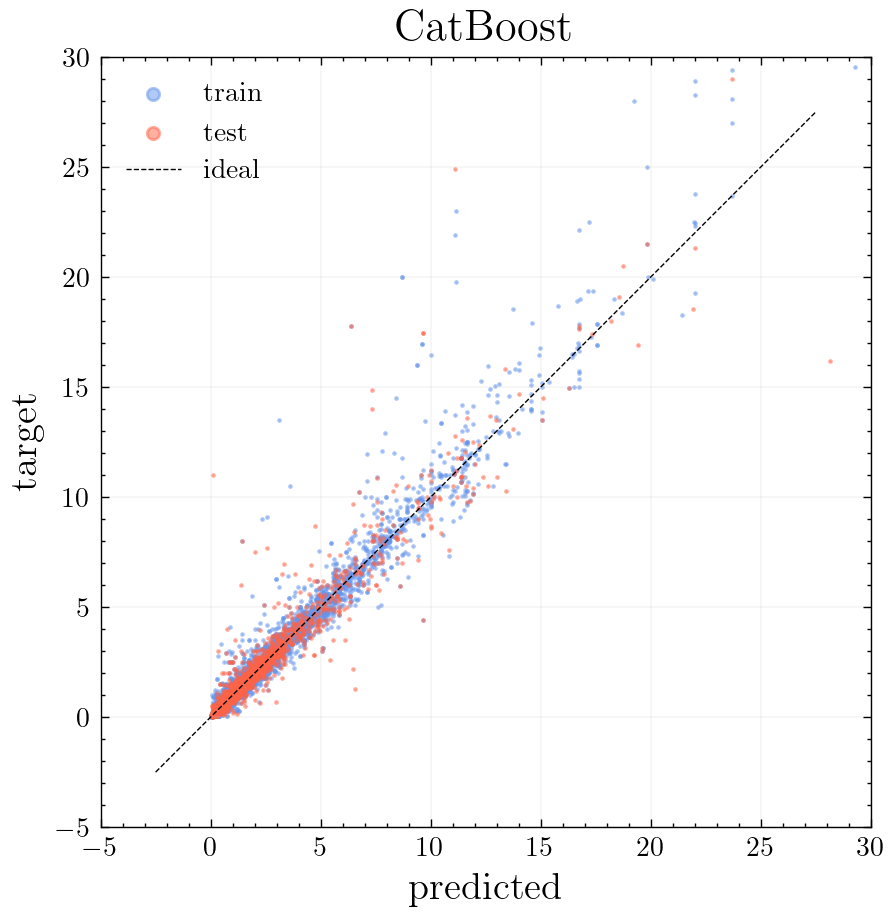

In [38]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -5
up_lim = 30  # some points 3-5 are out of the plot limits - outliers
delta = 2.5

ax.scatter(
    cat_model.predict(X_train),
    y_train, 
    c='cornflowerblue', s=0.5,
    alpha=0.5,
    label='train'
)
ax.scatter(
    preds_test,
    y_test, 
    c='tomato', s=0.5, 
    alpha=0.5,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('CatBoost', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

#### Result

We can see, that the number of outliers is less than were for `RandomForestRegressor` (see results in `optuned-forest.ipynb`)

We can see (not a surprise) that `CatBoost` perfomance is quite better than of `RandomForestRegressor` - let's continue to experiment!

### Anomalies searching

In [39]:
cat_cols_1 = ['box', 'drive_unit', 'drive', 'boost_type', 'car_class', 'fuel']  # no more than 9 options - binary_encoder
cat_cols_2 = ['country', 'car_type']  # more ore equal to 17 options

In [40]:
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # but ther is no NaN's in numerical data in our case
        ("scaler", StandardScaler())]
)

cat_transformer_1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.BinaryEncoder())
    ]
)

cat_transformer_2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.HashingEncoder(n_components=4))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_1', cat_transformer_1, cat_cols_1),
        ('cat_2', cat_transformer_2, cat_cols_2)
    ]
)

In [41]:
X_trans = X.copy()
    # transform categorical features
X_trans = preprocessor.fit_transform(X_trans)

In [43]:
clf_anomalies = IsolationForest(random_state=2023).fit(X_trans)

In [44]:
anomaly_or_not = clf_anomalies.predict(X_trans)

anomalies_ids = np.where(anomaly_or_not == -1)[0]
normal_ids = np.where(anomaly_or_not == 1)[0]

print(f'Number of anomaly points: {len(anomalies_ids)}')

Number of anomaly points: 6324


In [45]:
anomalies_ids

array([   52,    53,    54, ..., 22686, 22689, 22690])

#### Anomalies visualization

In [46]:
X_trans_cat = X.copy()

for num_column_name in num_cols:
    X_trans_cat[num_column_name] = (X_trans_cat[num_column_name] - num_train_means[num_column_name]) / num_train_vars[num_column_name]

for cat_column_name in cat_cols:    
    X_trans_cat[cat_column_name].fillna(cat_train_most_freq[cat_column_name], inplace=True)

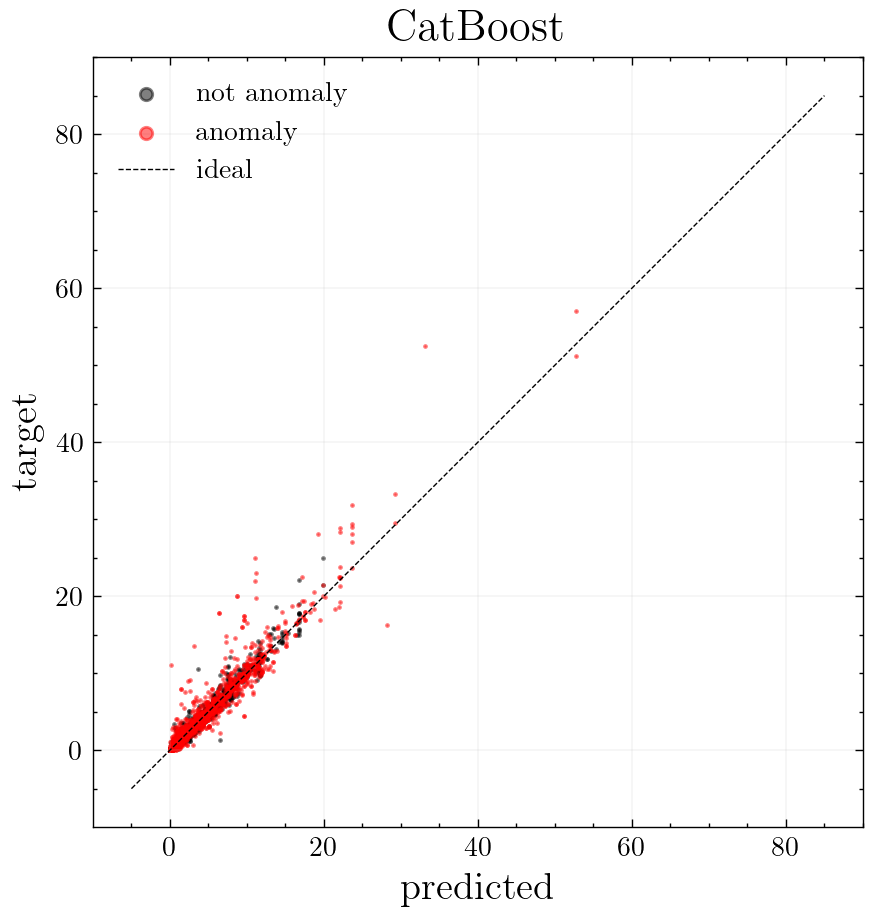

In [47]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -10
up_lim = 90
delta = 5

ax.scatter(
    cat_model.predict(X_trans_cat.iloc[normal_ids]),
    y.iloc[normal_ids], 
    c='k', s=0.5,
    alpha=0.5,
    label='not anomaly'
)
ax.scatter(
    cat_model.predict(X_trans_cat.iloc[anomalies_ids]),
    y.iloc[anomalies_ids],  
    c='r', s=0.5, 
    alpha=0.5,
    label='anomaly'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('CatBoost', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

#### Result

`IsolationForest` find a lot of anomalies - much more than the number of outliers, that can be seen by eyes. 

**Let's pause** that study and continue trying to predict cars prices  that are less than some `threshold`

### Price treshold for future prediction

We will **throw out** cars from `cars_ds` which `price` is greater than some `threshold`

In [67]:
price_th = 5  # in millions

In [68]:
print(f'Number of cars which price is greater than {price_th}m: {len(y[y > price_th])} (among {len(y)})')

Number of cars which price is greater than 5m: 1007 (among 22702)


In [69]:
X_th = X.iloc[np.where(y <= price_th)[0]]
y_th = y.iloc[np.where(y <= price_th)[0]]

In [70]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(
    X_th, y_th, 
    train_size=TRAIN_SZ, random_state=SEED_SPLITTING
)

In [71]:
print(f'Train size: {len(y_th_train)}')
print(f'Test size:  {len(y_th_test)}')

Train size: 17356
Test size:  4339


In [72]:
num_th_train_means, num_th_train_vars = normalize_num_features_catboost(num_cols, X_th_train, X_th_test)
cat_th_train_most_freq = replace_nans_cat_features_catboost(cat_cols, X_th_train, X_th_test)

### CatBoost

In [73]:
cat_th_model = CatBoostRegressor(
    iterations=5000,
    loss_function='MAE',
    random_seed=78,
    verbose=500,
    cat_features=cat_cols  # categorical features
)

In [74]:
cat_th_model.fit(X_th_train, y_th_train)

0:	learn: 0.6106182	total: 10.6ms	remaining: 53s
500:	learn: 0.1403975	total: 3.1s	remaining: 27.9s
1000:	learn: 0.1187001	total: 6.41s	remaining: 25.6s
1500:	learn: 0.1085028	total: 9.65s	remaining: 22.5s
2000:	learn: 0.1022825	total: 13s	remaining: 19.4s
2500:	learn: 0.0983186	total: 16.2s	remaining: 16.2s
3000:	learn: 0.0955758	total: 19.3s	remaining: 12.9s
3500:	learn: 0.0931446	total: 22.5s	remaining: 9.65s
4000:	learn: 0.0911336	total: 25.8s	remaining: 6.43s
4500:	learn: 0.0897026	total: 29s	remaining: 3.21s
4999:	learn: 0.0882991	total: 32s	remaining: 0us


#### Evaluating the model

In [75]:
preds_th_test = cat_th_model.predict(X_th_test)

In [76]:
mae_th_catboost = np.abs(preds_th_test - y_th_test).mean()  # l1-score (MAE)
mape_th_catboost = (np.abs(preds_th_test - y_th_test) / y_th_test).mean()  # MAPE


print(f'MAE for CatBoost model: {mae_th_catboost:.6f} ({mae_th_catboost * 1e3:.3f}k RUB)')
print(f'MAPE for CatBoost model: {mape_th_catboost * 100:.2f} %')

MAE for CatBoost model: 0.112447 (112.447k RUB)
MAPE for CatBoost model: 16.34 %


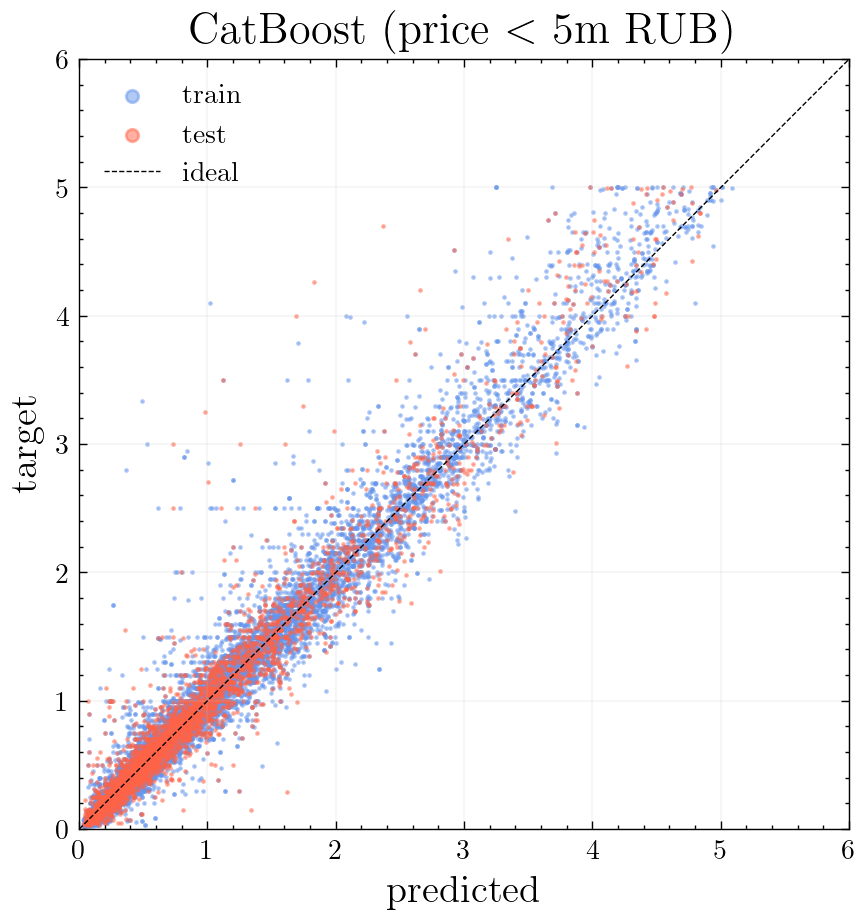

In [82]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = 0
up_lim = 6  # some points 3-5 are out of the plot limits - outliers
delta = 0

ax.scatter(
    cat_th_model.predict(X_th_train),
    y_th_train, 
    c='cornflowerblue', s=0.5,
    alpha=0.5,
    label='train'
)
ax.scatter(
    preds_th_test,
    y_th_test, 
    c='tomato', s=0.5, 
    alpha=0.5,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title(f'CatBoost (price $<$ {price_th}m RUB)', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

#### Result
MAPE metrics remain on the same value, which mans, that dataset _cutting_ does not result in dramatic quality improvement! 